<img src="./images/coronavirus_icon-1.jpg" style="float: left; margin: 20px; height: 75px">

# **Capstone: Covid-19 Study**

# 3.  Modeling

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
import pmdarima as pmd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [20]:
# Read in Datasets

merged_1_corr = pd.read_csv('../us_datasets/merged_1_corr.csv')
merged_2_corr = pd.read_csv('../us_datasets/merged_2_corr.csv')
merged_3_corr = pd.read_csv('../us_datasets/merged_3_corr.csv')
merged_1_corr_ratio = pd.read_csv('../us_datasets/merged_1_corr_ratio.csv')
time_series_df = pd.read_csv('../us_datasets/time_series_df.csv')
us_epidemiology = pd.read_csv('../us_datasets/us_epidemiology.csv', index_col = 'location_key')
us_index_merge_on = pd.read_csv('../us_datasets/us_index_merge_on.csv', index_col = 'location_key')

## Create Linear Regression Models for Inferential Analysis

### Fit LR models to three datasets: 01-01-2021, 09-01-2021, 05-13-2022

In [14]:
# Create X and y variables for three lr models

x1 = merged_1_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])
x1r = merged_1_corr_ratio.drop(columns = ['cumulative_confirmed', 'cov_confirmed_pop_ratio', 'Unnamed: 0'])
x2 = merged_2_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])
x3 = merged_3_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])

y1 = merged_1_corr['cumulative_confirmed']
y1r = merged_1_corr_ratio['cov_confirmed_pop_ratio']
y2 = merged_2_corr['cumulative_confirmed']
y3 = merged_3_corr['cumulative_confirmed']

In [15]:
# Train test split each dataset

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, random_state = 42)
x1r_train, x1r_test, y1r_train, y1r_test = train_test_split(x1r, y1r, random_state = 42)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, random_state = 42)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, random_state = 42)

In [16]:
# Scale, fit each model

sc1 = StandardScaler()
x1_train_sc = sc1.fit_transform(x1_train)
x1_test_sc = sc1.transform(x1_test)

sc1r = StandardScaler()
x1r_train_sc = sc1r.fit_transform(x1r_train)
x1r_test_sc = sc1r.transform(x1r_test)

sc2 = StandardScaler()
x2_train_sc = sc2.fit_transform(x2_train)
x2_test_sc = sc2.transform(x2_test)

sc3 = StandardScaler()
x3_train_sc = sc3.fit_transform(x3_train)
x3_test_sc = sc3.transform(x3_test)

lr1 = LinearRegression()
lr1.fit(x1_train_sc, y1_train)

lr1r = LinearRegression()
lr1r.fit(x1r_train_sc, y1r_train)

lr2 = LinearRegression()
lr2.fit(x2_train_sc, y2_train)

lr3 = LinearRegression()
lr3.fit(x3_train_sc, y3_train)

LinearRegression()

In [17]:
# Calculate train/test R2 scores for each model

print("01-01-2021 Dataset")
print(f'Training R2: {round(lr1.score(x1_train_sc, y1_train),3)}')
print(f'Testing R2: {round(lr1.score(x1_test_sc, y1_test),3)}')
print('='*26)
print("01-01-2021 Ratio Dataset")
print(f'Training R2: {round(lr1r.score(x1r_train_sc, y1r_train),3)}')
print(f'Testing R2: {round(lr1r.score(x1r_test_sc, y1r_test),3)}')
print('='*26)
print("09-01-2021 Dataset")
print(f'Training R2: {round(lr2.score(x2_train_sc, y2_train),3)}')
print(f'Testing R2: {round(lr2.score(x2_test_sc, y2_test),3)}')
print('='*26)
print("05-13-2022 Dataset")
print(f'Training R2: {round(lr3.score(x3_train_sc, y3_train),3)}')
print(f'Testing R2: {round(lr3.score(x3_test_sc, y3_test),3)}')

01-01-2021 Dataset
Training R2: 0.942
Testing R2: 0.891
01-01-2021 Ratio Dataset
Training R2: 0.447
Testing R2: 0.455
09-01-2021 Dataset
Training R2: 0.942
Testing R2: 0.886
05-13-2022 Dataset
Training R2: 0.968
Testing R2: 0.958


**Except for ratio dataset, LR models performed OK with the first two datasets being overfit.  The ratio dataset performed horribly compared to raw data datasets so that avenue of modeling for improved performance stops here.**

In [63]:
# Create dataframe of coefficients

df_1 = pd.DataFrame(lr1.coef_, index = x1.columns, columns = ['01-01-2021 Dataset'])
df_2 = pd.DataFrame(lr2.coef_, index = x2.columns, columns = ['09-01-2021 Dataset'])
df_3 = pd.DataFrame(lr3.coef_, index = x3.columns, columns = ['05-13-2022 Dataset'])

coef_df = pd.concat([df_1, df_2, df_3], axis = 1, join = 'outer')
coef_df.round(3).sort_values(by = '05-13-2022 Dataset', ascending = False)

,01-01-2021 Dataset,09-01-2021 Dataset,05-13-2022 Dataset
population,24773.317,21666.548,84438.382
cumulative_persons_fully_vaccinated,NaN,3304.241,10147.979
cancel_public_events,295.407,179.340,1854.869
average_temperature_celsius,-837.545,-142.974,1221.222
public_transport_closing,199.609,-254.200,758.208
rainfall_mm,57.619,79.875,356.075
snowfall_mm,-88.052,NaN,55.803
school_closing,248.130,-184.355,33.624
facial_coverings,-801.414,-645.432,-609.395
contact_tracing,-437.869,-924.819,-723.575


**Population is by far the largest influence on the target for each of the three datasets.  For the last two datasets with vaccination data, cumulative_persons_fully_vaccinated is the next largest factor.  From a government response view as contact tracing, debt relief, workplace closings and facial coverings become more strict, cases are reduced.  Oddly, as governments become stricter with closing public events, confirmed cases actually increase.  As expected, as life expectancy increases confirmed cases decreases, "confirmed" being the crucial word here.  With temperature and rainfall, whatever drives people inside (rainfall increases, temperature increases in summer, temperature decreases in winter) increases confirmed cases.**

## Create Predictive Regression Models 

### Optimize four regression models with pre and post vaccine datasets

In [6]:
# Create X and y variables; train/test split

x1 = merged_1_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])
x3 = merged_3_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])

y1 = merged_1_corr['cumulative_confirmed']
y3 = merged_3_corr['cumulative_confirmed']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, random_state = 42)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, random_state = 42)

In [119]:
# Instantiate pipelines 

# RidgeCV
ridge_cv_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('ridge_cv', RidgeCV())
])

# LassoCV
lasso_cv_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('lasso_cv', LassoCV())
])

# KNeighborsRegressor
knn_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# RandomForestRegressor
rf_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestRegressor())
])

In [120]:
# Set parameters for each pipeline

# RidgeCV pipeline parameters
ridge_cv_pipeline_params = {
    'ridge_cv__alphas': range(1,11)
}

# LassoCV pipeline parameters
lasso_cv_pipeline_params = {
    'lasso_cv__alphas': [None]
}

# KNeighborsRegressor pipeline parameters
knn_pipeline_params = {
    'knn__n_neighbors': range(1, 50, 2)
}

# RandomForestRegressor pipeline parameters
rf_pipeline_params = {
    'rf__n_estimators': range(250, 500, 50),
    'rf__max_depth': [None, 5, 10]
}

In [121]:
# Instantiate gridseach objects

# RidgeCV gridseach
ridge_cv_gs = GridSearchCV(ridge_cv_pipe,
                       ridge_cv_pipeline_params,
                       cv = 5)

# LassoCV gridsearch
lasso_cv_gs = GridSearchCV(lasso_cv_pipe,
                       lasso_cv_pipeline_params,
                       cv = 5)

# KNeighborsRegressor gridsearch
knn_gs = GridSearchCV(knn_pipe,
                       knn_pipeline_params,
                       cv = 5)

# RandomForestRegressor gridsearch
rf_gs = GridSearchCV(rf_pipe,
                       rf_pipeline_params,
                       cv = 5)

### Fit pre vaccine dataset

In [122]:
ridge_cv_gs.fit(x1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ridge_cv', RidgeCV())]),
             param_grid={'ridge_cv__alphas': range(1, 11)})

In [123]:
lasso_cv_gs.fit(x1_train, y1_train)

/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60079190.18865204, tolerance: 45413526.25748
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79654908.87906647, tolerance: 45413526.25748
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114475770.05779266, tolerance: 45413526.25748
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_de

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('lasso_cv', LassoCV())]),
             param_grid={'lasso_cv__alphas': [None]})

In [125]:
knn_gs.fit(x1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(1, 50, 2)})

In [127]:
rf_gs.fit(x1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__n_estimators': range(250, 500, 50)})

In [128]:
# Output best parameters, best score, test score

gs_dict = {'RidgeCV' : ridge_cv_gs, 
           'LassoCV' : lasso_cv_gs, 
           'KNeighborsRegressor' : knn_gs, 
           'RandomForestRegressor' : rf_gs, 
          }

for key, value in gs_dict.items():
    print('=' * 40)
    print(key)
    print(f'Train Score: {(value.best_score_).round(3)}')
    print(f'Test Score: {(value.score(x1_test, y1_test)).round(3)}')
    print(f'Best Parameters: {value.best_params_}')

RidgeCV
Train Score: 0.891
Test Score: 0.889
Best Parameters: {'ridge_cv__alphas': 3}
LassoCV
Train Score: 0.884
Test Score: 0.887
Best Parameters: {'lasso_cv__alphas': None}
KNeighborsRegressor
Train Score: 0.782
Test Score: 0.871
Best Parameters: {'knn__n_neighbors': 1}
RandomForestRegressor
Train Score: 0.855
Test Score: 0.968
Best Parameters: {'rf__max_depth': 10, 'rf__n_estimators': 250}


**RandomForestRegressor has the best test score but is massively overfit and takes a very long time to run.  As datasets continue to grow this may be a problem.  For the pre-vaccine datasets I'd choose RidgeCV initially, depending on the data trends of course. I'd choose RidgeCV for its combination of Ok test and train scores and the speed it can create predictions that should be good enough to inform on general trends for high level decision making.**  

### Fit post vaccine dataset

In [111]:
ridge_cv_gs.fit(x3_train, y3_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ridge_cv', RidgeCV())]),
             param_grid={'ridge_cv__alphas': range(1, 11)})

In [112]:
lasso_cv_gs.fit(x3_train, y3_train)

/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e+10, tolerance: 1.800e+09
  model = cd_fast.enet_coordinate_descent(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 801459713.7767334, tolerance: 793316571.7001983
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1009704716.2032471, tolerance: 793316571.7001983
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/p

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('lasso_cv', LassoCV())]),
             param_grid={'lasso_cv__alphas': [None]})

In [113]:
knn_gs.fit(x3_train, y3_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(1, 50, 2)})

In [114]:
rf_gs.fit(x3_train, y3_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__n_estimators': range(250, 500, 50)})

In [116]:
# Output best parameters, best score, test score

gs_dict = {'RidgeCV' : ridge_cv_gs, 
           'LassoCV' : lasso_cv_gs, 
           'KNeighborsRegressor' : knn_gs, 
           'RandomForestRegressor' : rf_gs, 
          }

for key, value in gs_dict.items():
    print('=' * 40)
    print(key)
    print(f'Train Score: {(value.best_score_).round(3)}')
    print(f'Test Score: {(value.score(x3_test, y3_test)).round(3)}')
    print(f'Best Parameters: {value.best_params_}')

RidgeCV
Train Score: 0.959
Test Score: 0.958
Best Parameters: {'ridge_cv__alphas': 1}
LassoCV
Train Score: 0.954
Test Score: 0.959
Best Parameters: {'lasso_cv__alphas': None}
KNeighborsRegressor
Train Score: 0.881
Test Score: 0.943
Best Parameters: {'knn__n_neighbors': 1}
RandomForestRegressor
Train Score: 0.896
Test Score: 0.976
Best Parameters: {'rf__max_depth': None, 'rf__n_estimators': 450}


**RandomForestRegressor is overfit with RidgeCV and LassoCV performing very well with the added benefit of producing predictions in a timely fashion.  For this reason, either regularized LR model would be a good choice.**

## Create Forecast models
Reference: GA 9.02-lesson-linear-ts-models

### Explore time series data and format for forecasting

In [65]:
# Verify target dataset

us_epidemiology.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2550043 entries, US_AK to US_WY_56045
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0.1          int64  
 1   Unnamed: 0            int64  
 2   date                  object 
 3   new_confirmed         float64
 4   new_deceased          float64
 5   new_recovered         float64
 6   new_tested            float64
 7   cumulative_confirmed  float64
 8   cumulative_deceased   float64
 9   cumulative_recovered  float64
 10  cumulative_tested     float64
dtypes: float64(8), int64(2), object(1)
memory usage: 265.7+ MB


In [66]:
# Visualize date to identify any required changes

us_epidemiology.tail()

,Unnamed: 0.1,Unnamed: 0,date,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested
location_key,,,,,,,,,,,
US_WY_56045,2550038,12446226,2022-05-09,0.0,0.0,NaN,NaN,1589.0,18.0,NaN,NaN
US_WY_56045,2550039,12446227,2022-05-10,-1.0,0.0,NaN,NaN,1588.0,18.0,NaN,NaN
US_WY_56045,2550040,12446228,2022-05-11,0.0,0.0,NaN,NaN,1588.0,18.0,NaN,NaN
US_WY_56045,2550041,12446229,2022-05-12,0.0,0.0,NaN,NaN,1588.0,18.0,NaN,NaN
US_WY_56045,2550042,12446230,2022-05-13,0.0,0.0,NaN,NaN,1588.0,18.0,NaN,NaN


In [67]:
# merge us_epidemiology with us_index_merge_on to remove state level location_key rows allowing for a groupby sum() to forecast 

merged_ts = pd.merge(us_epidemiology, us_index_merge_on, how = 'right', left_index = True, right_index = True)

In [68]:
# Verify index is correct, ie. doesn't start with state level US_AK

merged_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2431888 entries, US_AK_02013 to US_WY_56045
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0.1          float64
 1   Unnamed: 0            float64
 2   date                  object 
 3   new_confirmed         float64
 4   new_deceased          float64
 5   new_recovered         float64
 6   new_tested            float64
 7   cumulative_confirmed  float64
 8   cumulative_deceased   float64
 9   cumulative_recovered  float64
 10  cumulative_tested     float64
 11  subregion2_name       object 
dtypes: float64(10), object(2)
memory usage: 241.2+ MB


In [69]:
# Check nulls

merged_ts.isnull().sum()

Unnamed: 0.1                  4
Unnamed: 0                    4
date                          4
new_confirmed              3098
new_deceased              13981
new_recovered           2431888
new_tested              2431888
cumulative_confirmed          4
cumulative_deceased       10848
cumulative_recovered    2431888
cumulative_tested       2431888
subregion2_name               0
dtype: int64

In [70]:
# Group 'cumulative_confirmed' by date to visualize all US cases

df_cc = merged_ts.groupby('date')['cumulative_confirmed'].sum().reset_index(name = 'cumulative_confirmed')
df_cc

,date,cumulative_confirmed
0,2020-01-21,1.0
1,2020-01-22,1.0
2,2020-01-23,1.0
3,2020-01-24,2.0
4,2020-01-25,3.0
...,...,...
962,2022-09-09,4260461.0
963,2022-09-10,4160692.0
964,2022-09-11,4171015.0
965,2022-09-12,4264428.0


In [71]:
#  Set index 'date' as datetime type

df_cc['date'] = pd.to_datetime(df_cc['date'])
df_cc.set_index('date', inplace = True)
df_cc.sort_index(inplace = True)

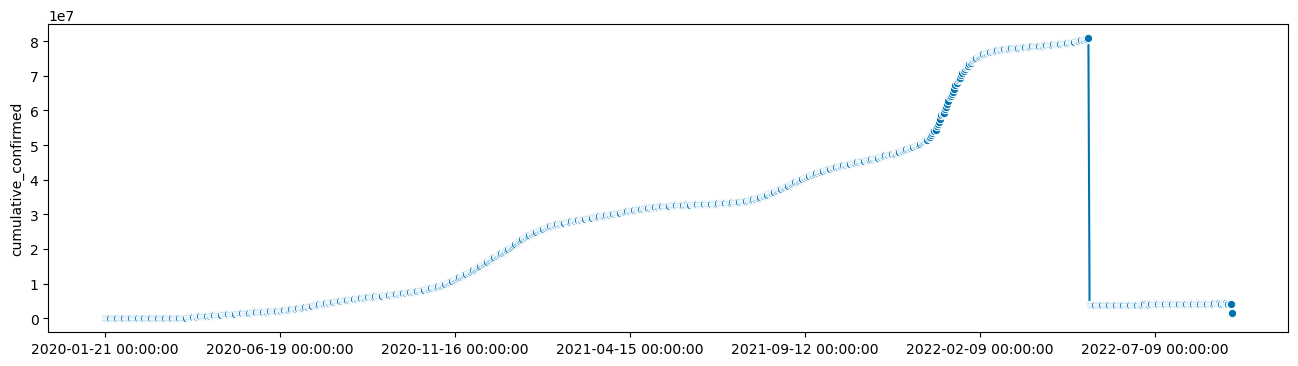

In [72]:
# Verify data quality

plot_series(df_cc.cumulative_confirmed);

In [73]:
# Most states stop reporting after 5/14/2022; end dataset at this date

df_cc = df_cc[df_cc.index < '2022-05-14']

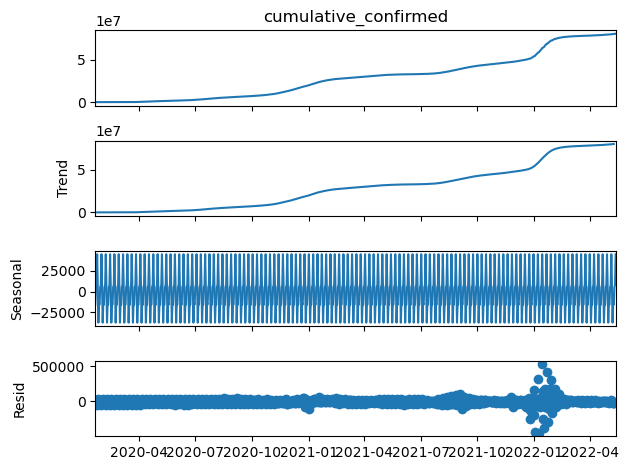

In [74]:
# Plot df_cc with associated trend, seasonality, and residual components assuming a linear trend

decomp_df_cc = seasonal_decompose(df_cc['cumulative_confirmed']) 
decomp_df_cc.plot();

**The time series dataset has a general positive linear trend with no seasonality and very low residuals.**

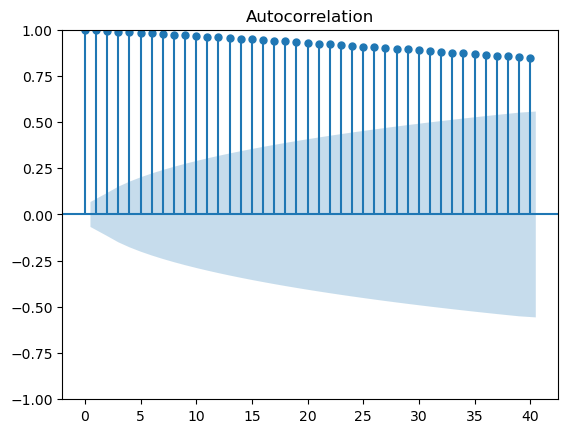

In [75]:
# Generate autocorrelation plot

plot_acf(df_cc['cumulative_confirmed'], lags = 40);

**A varity of lags were plotted with all having a similar shape.  The plot displayed large, positive values at low lags inferring that a trend exits.  The chart is smooth, not scalloped, indicating there isn't a seasonal aspect to the dataset.** 

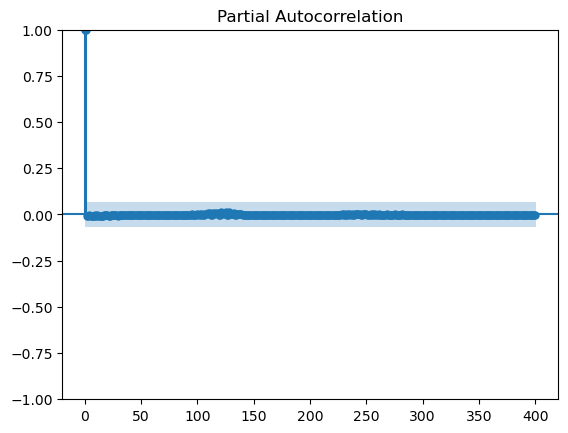

In [76]:
# Generate autocorrelation plot

plot_pacf(df_cc['cumulative_confirmed'], lags = 400);

**The above partial autocorrelation chart displays no seasonality and no statistically significant correlation.**

In [77]:
# Add lag = 20 columns to df_cc and drop nulls

for i in range(1,11):
    df_cc[f'lag_{i}'] = df_cc['cumulative_confirmed'].shift(i)
    
df_cc.dropna(inplace = True)

/var/folders/qy/nr1f_j6j7nx50jtp9tqqgftc0000gn/T/ipykernel_19761/1574099588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc[f'lag_{i}'] = df_cc['cumulative_confirmed'].shift(i)
/var/folders/qy/nr1f_j6j7nx50jtp9tqqgftc0000gn/T/ipykernel_19761/1574099588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc[f'lag_{i}'] = df_cc['cumulative_confirmed'].shift(i)
/var/folders/qy/nr1f_j6j7nx50jtp9tqqgftc0000gn/T/ipykernel_19761/1574099588.py:4: SettingWithCopyWarning: 
A value is trying to be set on 

In [78]:
# TTS the y-lagged dataframe

X_train, X_test, y_train, y_test = train_test_split(df_cc.drop(columns = 'cumulative_confirmed'),
                                                    df_cc['cumulative_confirmed'],
                                                    shuffle = False)

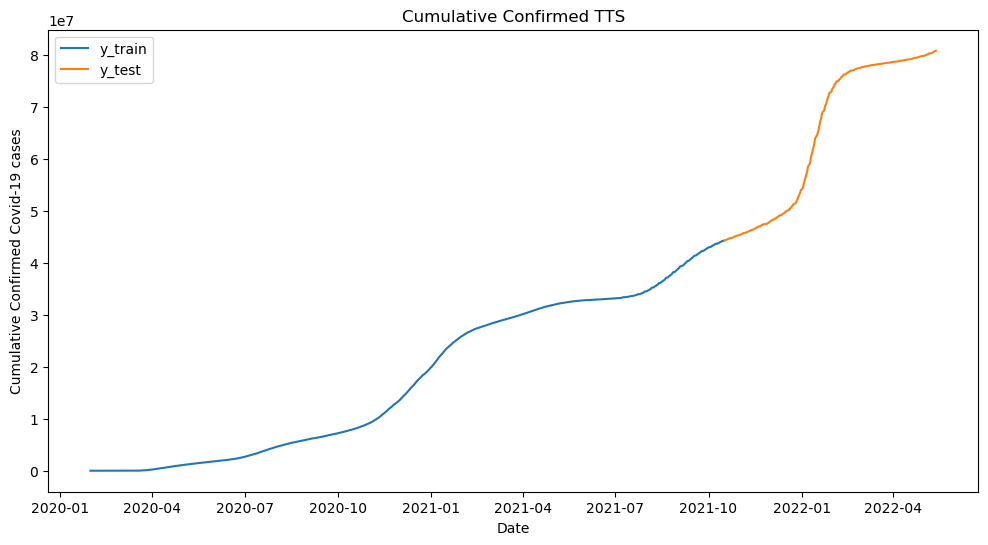

In [79]:
# Plot the TTS to ensure y is split properly

plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.title('Cumulative Confirmed TTS')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Covid-19 cases')
plt.legend();

In [80]:
# Instantiate and fit a LR model on df_cc

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [81]:
# generate predictions over test set

y_preds = lr.predict(X_test)

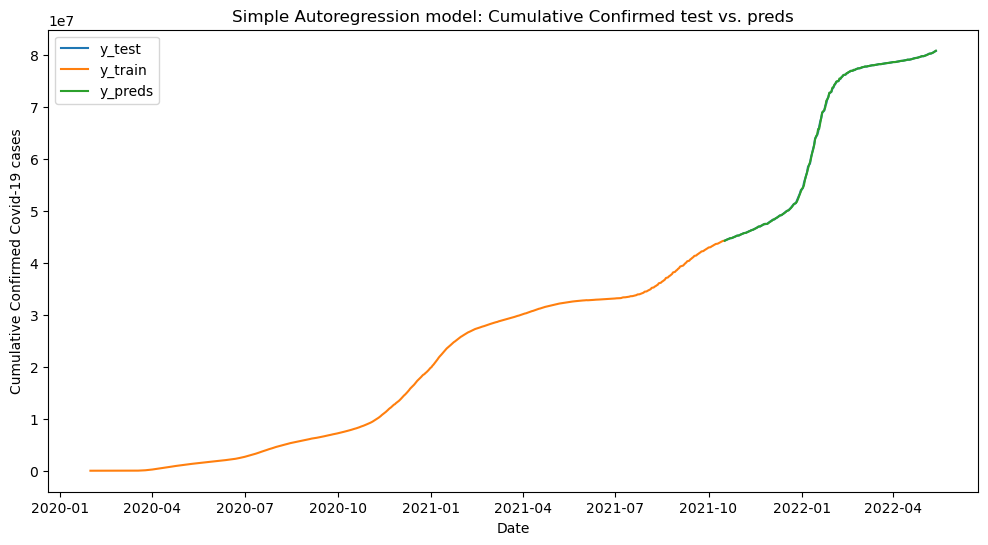

In [82]:
# plot predictions

plt.figure(figsize = (12, 6))
plt.plot(y_test, label = 'y_test')
plt.plot(y_train, label = 'y_train')
plt.plot(y_test.index, y_preds, label = 'y_preds')
plt.title('Simple Autoregression model: Cumulative Confirmed test vs. preds')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Covid-19 cases')
plt.legend()
plt.savefig('./images/simple_autoregression');

**y-preds overlays y-test perfectly.  The above model is based off 10 lags.**

In [83]:
# Re-establish y

df_cc = df_cc[['cumulative_confirmed']]

In [84]:
# Augmented Dickey-Fuller test to determine stationarity

adfuller(df_cc)

(0.5332669889187962,
 0.9858499051442031,
 21,
 812,
 {'1%': -3.4384289321263126,
  '5%': -2.865105979079729,
  '10%': -2.568668841575869},
 19769.95955184543)

P-value is nearly 1, much greater than 0.05, so we can conclude the time series is not stationarity. We must improve stationarity to use ARIMA.

### Detrend dataset to improve stationarity
Source: GA 9.04-lesson-forecasint-ii

In [85]:
# reconfigure y in order to detrend

X = pd.to_numeric(df_cc.index)
X = X.to_numpy().reshape(-1, 1)
y = df_cc['cumulative_confirmed']

In [86]:
# Instatiate lr model

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [87]:
# calculate pred and detrend to attempt to improve dataset stationairity

pred = lr.predict(X)
detrend = y - pred

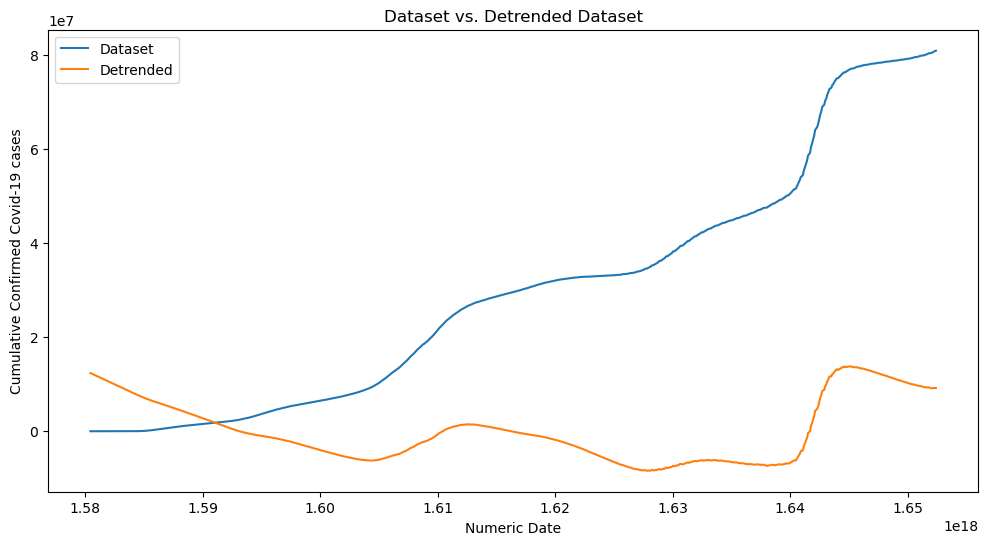

In [88]:
# Plot dataset w/ detrended dataset

plt.figure(figsize = (12, 6))
plt.plot(X, y, label = 'Dataset')
plt.plot(X, detrend, label = 'Detrended')
plt.title('Dataset vs. Detrended Dataset')
plt.xlabel('Numeric Date')
plt.ylabel('Cumulative Confirmed Covid-19 cases')
plt.legend();

In [89]:
# Check stationarity

adfuller(detrend)

(-2.2039502066534595,
 0.20481488497148148,
 21,
 812,
 {'1%': -3.4384289321263126,
  '5%': -2.865105979079729,
  '10%': -2.568668841575869},
 19765.2684939286)

**Detrending did not improve p-value to the point the dataset is stationary.**

### Difference dataset to improve stationarity

In [90]:
# difference dataset

df_cc['difference'] = df_cc['cumulative_confirmed'].diff()

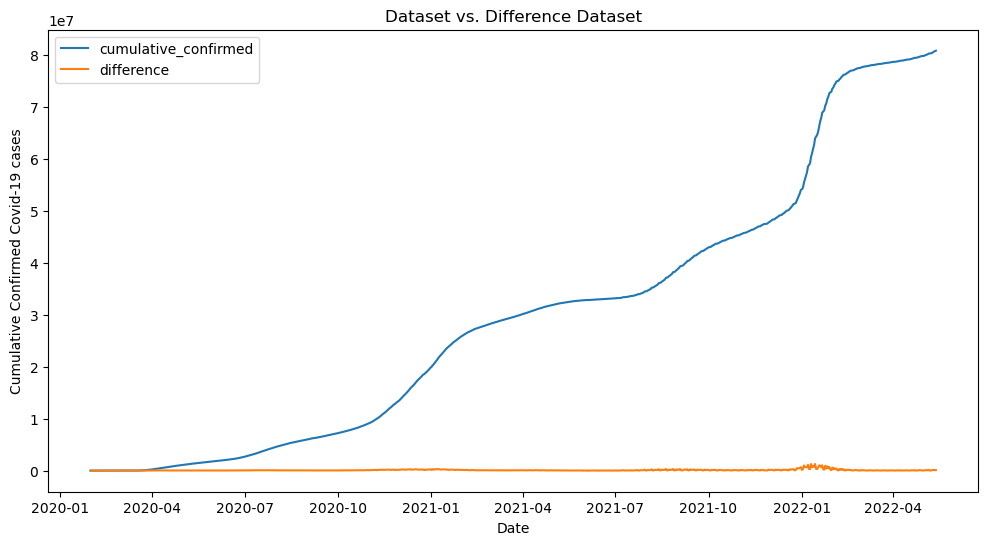

In [91]:
# plot dataset vs differenced  

plt.figure(figsize = (12, 6))
plt.plot(df_cc.cumulative_confirmed, label = 'cumulative_confirmed')
plt.plot(df_cc.difference, label = 'difference')
plt.title('Dataset vs. Difference Dataset')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Covid-19 cases')
plt.legend();

In [92]:
df_cc.dropna(inplace = True)

In [93]:
# Check stationarity

adfuller(df_cc.difference)

(-3.3920477026494003,
 0.011232970633197104,
 21,
 811,
 {'1%': -3.4384389256151358,
  '5%': -2.8651103842072048,
  '10%': -2.568671188193778},
 19744.78532156366)

**Using difference, p-value is now below 0.05; dataset exhibits stationarity.**

### Create ARIMA model

In [99]:
# TTS dataset for arima model

y_train, y_test = temporal_train_test_split(df_cc['cumulative_confirmed'], test_size = 240)

In [101]:
# instantiate and fit data to auto-arima, not seasonal and one difference level

model = pmd.auto_arima(y_train, d = 1, seasonal = False, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13905.052, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14845.084, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14178.344, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14590.104, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15271.412, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13949.201, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13958.516, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13887.371, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13927.213, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13881.933, Time=0.46 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13910.145, Time=0.25 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=13871.144, Time=0.40 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=13905.892, Time=0.33 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=13898.069, Time=0.99 sec
 ARIMA(4,1,3)(0,0,0

In [102]:
model

ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [103]:
# calculate arima predictions

auto_arima_preds = model.predict(240)

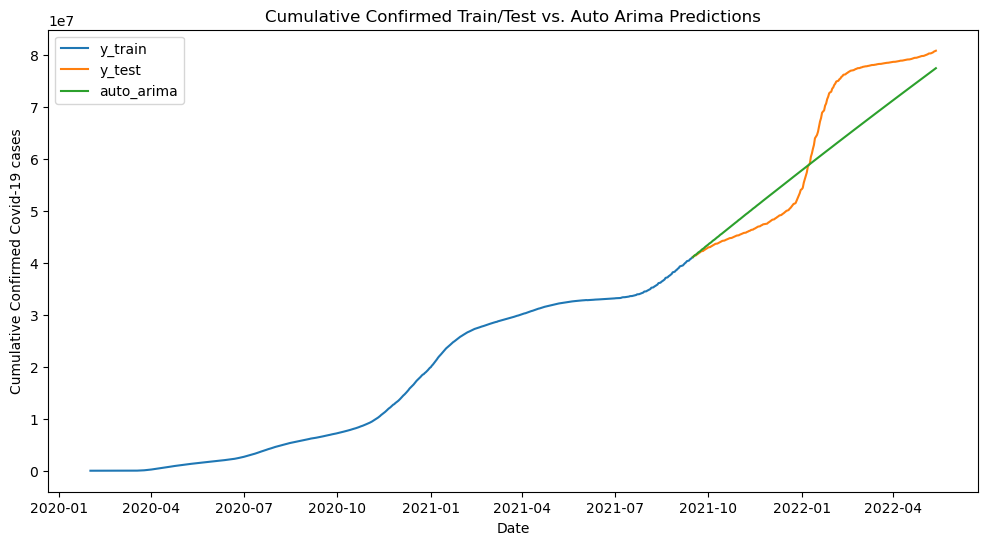

In [104]:
# plot predictions

plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, auto_arima_preds, label = 'auto_arima')
plt.title('Cumulative Confirmed Train/Test vs. Auto Arima Predictions')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Covid-19 cases')
plt.legend()
plt.savefig('./images/auto_arima');

**The ARIMA model prediction continues the trend from its initiation point, continuing to the end of the forecast timeframe in a linear fashion.  This model may be best suited for longer time horizons whereas the simple LR autoregression model may work for very short timeframes.**

## Conclusions

**This study set out to develop a set of tools that will help policy makers better address future health crisis as they arise and evolve.  To accomplish this task three models were developed to manage different issues.**  

**First, inferential analysis on linear regression models were used to identify factors that contribute to the spread of the virus both pre and post vaccine rollout. Population is by far the largest influence on the number of confirmed Covid cases.  Post vaccine rollout, cumulative_persons_fully_vaccinated is the next largest factor.  From a policy standpoint, as contact tracing, debt relief, workplace closings and facial coverings become more strict, cases were reduced.  Unexpectedly, as public events were cancelled and closed, confirmed cases actually increased.  As expected, as life expectancy increases confirmed cases decrease.  With weather factors, whatever drives people inside (rainfall increases, temperature increases in summer, temperature decreases in winter) increases confirmed cases.**

**Second, four regression models (RidgeCV, LasoCV, KNN, RandomForest) were tested to identify the best model to correct and/or substantiate pandemic spread data from other sources.  RandomForest had the best test scores but was massively overfit and took a long time to run.  RidgeCV performed well enough on both pre and post vaccine data with scores ~0.90 and ~0.96 respectively with quick turnaround on predictions.  Because of this, RidgeCV is our choice model for this application.**

**Third, forecast models were developed to predict future case numbers in order to proactively plan and implement policies.  A simple 10 lag autoregression model performed very well in the very short term.  For longer term forecasts an ARIMA model with auto-arima optimization was created.  In the short term this model was slightly off but still performed well given that the dataset is niether seasonal or stationary.**

**Recommendations: compile tools into a single dashboard, continue to optize models as data volume increases**